11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


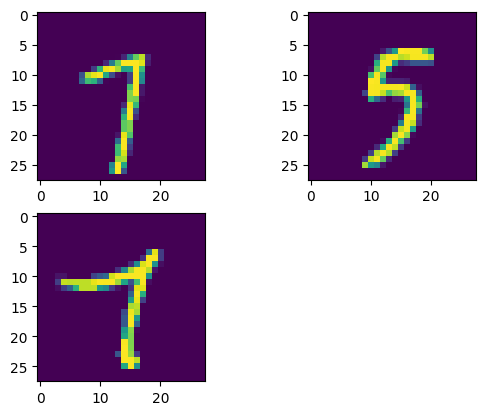

In [2]:
import numpy as np
import pandas as pd

import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
#from keras import backend as K

import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255

img_width = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])

plt.subplot(222)
plt.imshow(x_train[420][:,:,0])

plt.subplot(223)
plt.imshow(x_train[4200][:,:,0])


In [10]:
import tensorflow as tf

In [3]:
latent_dim = 2
input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mu = Dense(latent_dim, name='latent_mu')(x)
z_sigma = Dense(latent_dim, name='latent_sigma')(x)

def sample_z(args):
    z_mu,z_sigma = args
    eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
    return z_mu + K.exp(z_sigma / 2) *eps



z = Lambda(sample_z, output_shape=(latent_dim,),name='z')([z_mu, z_sigma])


encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())



Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     36,928 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12544)     │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │    401,440 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_mu (Dense)   │ (None, 2)         │         66 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_sigma        │ (None, 2)         │         66 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ latent_mu[0][0],  │
│                     │                   │            │ latent_sigma[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 494,244 (1.89 MB)

 Trainable params: 494,244 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:

decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation = 'relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(x)

x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

z_decoded = decoder(z)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12544)          │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
import keras
import tensorflow as tf

class CustomLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x_flat = Flatten()(x)
        z_decoded_flat = Flatten()(z_decoded)
        
        # Reconstruction loss
        recon_loss = keras.metrics.binary_crossentropy(x_flat, z_decoded_flat)
        recon_loss = tf.reduce_mean(recon_loss, axis=-1)

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(1 + z_sigma - tf.square(z_mu) - tf.exp(z_sigma), axis=-1)

        return recon_loss + kl_loss
    
    def call(self, inputs):
        x, z_decoded, z_mu, z_sigma = inputs
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss)
        return x

# Example inputs (for demonstration purposes)
input_img = Input(shape=(28, 28, 1), name='encoder_input')
z_decoded = Input(shape=(28, 28, 1), name='decoded_output')
z_mu = Input(shape=(latent_dim,), name='z_mu')  # latent_dim should be defined
z_sigma = Input(shape=(latent_dim,), name='z_sigma')  # latent_dim should be defined

# Instantiate the custom layer
y = CustomLayer()([input_img, z_decoded, z_mu, z_sigma])

# Define the VAE model
vae = Model([input_img, z_decoded, z_mu, z_sigma], y, name='vae')

# Compile the VAE model
vae.compile(optimizer='adam')
vae.summary()

# Dummy data for demonstration (replace with actual data)
#x_train = tf.random.normal((100, 28, 28, 1))  # example training data

# Train the model
#vae.fit([x_train, x_train, tf.random.normal((100, latent_dim)), tf.random.normal((100, latent_dim))],
 #       epochs=10, batch_size=32, validation_split=0.2)


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoded_output      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mu (InputLayer)   │ (None, 2)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_sigma             │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_layer_19     │ (None, 28, 28, 1) │          0 │ encoder_input[0]… │
│ (CustomLayer)       │                   │            │ decoded_output[0… │
│                     │                   │            │ z_mu[0][0],       │
│                     │                   │            │ z_sigma[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model
vae.fit([x_train, z_decoded, z_mu, z_sigma], None, epochs=10, batch_size=32, validation_split=0.2)


In [ ]:
mu, _, _ = encoder.predict(x_test)
plt.figure(figsize=(8,10))
plt.scatter(mu[:,0], mu[:,1], c=y_test, cmap='brg')
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.colorbar()
plt.show()

In [ ]:
sample_vector = np.array([[1,3]])
decoded_example= decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)